In [89]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
from scipy import stats
import os
import _pickle as cPickle


def save_pvalues(dict):
    pickle_path = 'D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/pvalues.pkl'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as fp:
            pvalue_dict = cPickle.load(fp)
    else:
        pvalue_dict = {}
        
    
    for key in dict.keys():
        pvalue_dict[key] = dict[key]
     
    with open(pickle_path, 'wb') as fp:
        cPickle.dump(pvalue_dict, fp)
        
def test_significance(nomon_data, rowcol_data):
    shapiro_stat, shapiro_p = stats.shapiro(nomon_data - rowcol_data)
    
    if shapiro_p <= 0.05:
        print("Normality Assumption Violated. Running Wilcoxin", shapiro_stat, shapiro_p)

        Z_stat, p_value = stats.wilcoxon(nomon_data-rowcol_data)
        r = Z_stat / (len(nomon_data)*(len(nomon_data)+1)/2)
        return {"Z": Z_stat, "r": r, "p": p_value}
    else:
        print("Running Dependant T test")
        t_stat, p_value = stats.ttest_rel(nomon_data, rowcol_data)
        df = len(nomon_data)-1
        r = np.sqrt(t_stat**2/(t_stat**2+df))
        return {"t": t_stat, "r": r, "p": p_value}
    
def calculate_quantiles(plot_df, metric):
    lower_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.25)
    lower_quantiles = lower_quantiles.reset_index()
    nomon_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "RCS"][metric].values
    
    upper_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.75)
    upper_quantiles = upper_quantiles.reset_index()
    nomon_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "RCS"][metric].values
    
    return {"lower": {"nomon": nomon_lower_quantiles, "rowcol": rowcol_lower_quantiles},
            "upper": {"nomon": nomon_upper_quantiles, "rowcol": rowcol_upper_quantiles}}      
    
    
def r(x, y):
    return x != y


def calc_MSD(a, b):
    
    if a[-1] == "_" or a[-1] == " ":
        a = a[:-1]
    if b[-1] == "_" or b[-1] == " ":
        b = b[:-1]

    a = np.array(list(a))
    b = np.array(list(b))

    D = np.zeros((a.size, b.size))

    for i in range(a.size):
        D[i, 0] = i

    for j in range(b.size):
        D[0, j] = j

    for i in range(a.size):
        for j in range(b.size):
            D[i, j] = min(D[i-1, j]+1, D[i, j-1]+1, D[i-1, j-1] + r(a[i], b[j]))
    return D[-1, -1], D[-1, -1] / b.size

time_rotate_li = [4]
for i in range(21):
    time_rotate_li += [4*np.exp((-i)/10)]
    
scan_delay_li = [2]
for i in range(21):
    scan_delay_li += [2*np.exp((-i)/14)]

extra_delay_li = [2]
for k in range(11):
    extra_delay_li += [0.2*(10-k)]


mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDB"
)
mycursor = mydb.cursor()

user_df = pd.read_sql('SELECT id, nomon_sessions, rowcol_sessions, dates FROM study_info', con=mydb)

users=[98, 133, 140, 161, 168, 175, 182, 189, 196, 203, 210, 224, 231, 238, 245, 252, 259]
user_df = user_df[user_df["id"].isin(users)].drop_duplicates()
user_df.dates = user_df.dates.apply(lambda x: json.loads(x)[-1])

user_df

,id,nomon_sessions,rowcol_sessions,dates
7,98,10,10,2020-8-21
12,133,10,10,2020-9-11
13,140,10,10,2020-9-11
16,161,10,10,2020-9-14
17,168,10,10,2020-9-11
18,175,10,10,2020-9-13
19,182,10,10,2020-9-12
20,189,7,7,2020-9-13
21,196,10,10,2020-9-7
22,203,3,3,2020-9-11


In [90]:
with open("D:/Users/nickb/PycharmProjectsD/NomonWeb/resources/phrases_oov.json", 'rb') as fp:
    oov_phrases = json.load(fp)

entry_df = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "typed_len", "num_click", "num_sel", 
                                 "num_corr", "start", "end", "Final Error Rate", "Time Rotate", 
                                 "Scan Delay", "Extra Delay", "is_oov"])

users = user_df.id.values
software_names = {"nomon": "Nomon", "rowcol": "RCS"}
for user in users:
    print(user)
    for software in software_names.keys():
        software_sessions = user_df[(user_df.id == user)][software+"_sessions"].values[0]
        for session_num in range(1, software_sessions+1):
            data_table = software + "_session_"+str(session_num)+"_user_"+str(user)
            
            mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
            phrase_nums = np.array(mycursor.fetchall()).T[0]
            for phrase_num in phrase_nums:
                trial_data = {"id": user, "Session Number": session_num, "Keyboard": software_names[software], "phrase_num": phrase_num}
                
                mycursor.execute("SELECT abs_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp ASC")
                click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
                while len(click_times[0]) == 0:
                    click_times = click_times[1:]
                first_press = click_times[0][0]
                num_clicks = sum([len(click_arr) for click_arr in click_times])
                # if (software == "rowcol"):
                #     num_mispress = sum([1 for click_arr in click_times if len(click_arr) >2])
                # else:
                num_mispress = 0
                
                mycursor.execute("SELECT timestamp FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                last_selection = mycursor.fetchall()[0][0]

                mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                typed_text = mycursor.fetchall()[0][0]
                typed_len = len(typed_text)
                if session_num == 10:
                    typed_len /= 2
                
                mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
                phrase_text = mycursor.fetchall()[0][0]

                uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
                
                is_oov = ["IV", "OOV"][phrase_text in oov_phrases]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
                num_selections = mycursor.fetchall()[0][0]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " AND (selection = '@' OR selection = '#' OR selection = 'undefined')")
                num_corrections = mycursor.fetchall()[0][0]
                
                if software == "nomon":
                    mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    rotate_ind = mycursor.fetchall()[0][0]
                    trial_data["Time Rotate"] = time_rotate_li[rotate_ind]
                else:
                    mycursor.execute("SELECT scan_delay, extra_delay FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    scan_delay, extra_delay = mycursor.fetchall()[0]
                    trial_data["Scan Delay"] = scan_delay_li[scan_delay]
                    trial_data["Extra Delay"] = extra_delay_li[extra_delay]
                
                
                trial_data["typed_len"] = typed_len
                trial_data["start"] = first_press
                trial_data["end"] = last_selection
                trial_data["num_click"] = num_clicks
                trial_data["num_sel"] = num_selections
                trial_data["num_corr"] = num_corrections + num_mispress
                trial_data["Final Error Rate"] = uncorrected_error
                trial_data["is_oov"] = is_oov
                
                
                entry_df = entry_df.append(trial_data, ignore_index=True)

entry_df["Entry Rate (wpm)"] = entry_df.typed_len / (entry_df.end - entry_df.start) / 5 * 60
entry_df["Entry Rate (selections/min)"] = entry_df.typed_len / (entry_df.end - entry_df.start) * 60
entry_df["Click Load (clicks/char)"] = entry_df.num_click / entry_df.typed_len
entry_df["Correction Rate"] = entry_df.num_corr / entry_df.num_sel

entry_df["id"] = pd.to_numeric(entry_df["id"])
entry_df["Session Number"] = pd.to_numeric(entry_df["Session Number"])
entry_df["Entry Rate (wpm)"] = pd.to_numeric(entry_df["Entry Rate (wpm)"])
entry_df["Entry Rate (selections/min)"] = pd.to_numeric(entry_df["Entry Rate (selections/min)"])
entry_df["Click Load (clicks/char)"] = pd.to_numeric(entry_df["Click Load (clicks/char)"])
entry_df["Correction Rate"] = pd.to_numeric(entry_df["Correction Rate"])
entry_df["Final Error Rate"] = pd.to_numeric(entry_df["Final Error Rate"])
entry_df["Time Rotate"] = pd.to_numeric(entry_df["Time Rotate"])

grouped_df = entry_df.groupby(['id', 'Session Number', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
grouped_df.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
grouped_df = grouped_df.reset_index()


98
133
140
161
168
175
182
189
196
203
210
224
231
238
245
252
259


<Figure size 432x288 with 0 Axes>

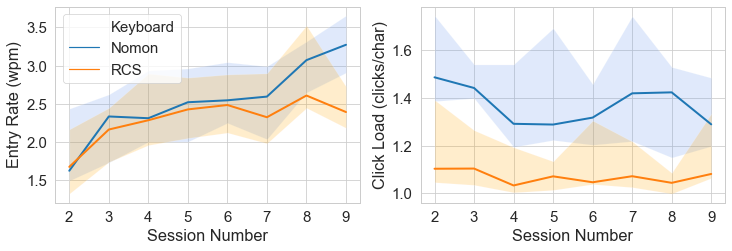

In [111]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

plot_df = grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)]

metrics = ['Entry Rate (wpm)', "Click Load (clicks/char)"]
a4_dims = (12, 4)
_, axes = plt.subplots(1, 2, figsize=a4_dims)
for ax_ind, metric in enumerate(metrics):
    ax = axes[ax_ind]
    plt.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    sns.lineplot(x="Session Number", y=metric, hue="Keyboard", estimator=np.median,
                  data=plot_df, ax=ax, ci=None, linewidth=2)
    
    quantiles = calculate_quantiles(plot_df, metric)
    
    if ax_ind == 1:
        ax.get_legend().remove()
    
    ax.fill_between(range(2, 10), quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
    ax.fill_between(range(2, 10), quantiles["lower"]["rowcol"], quantiles["upper"]["rowcol"],
                    where=quantiles["upper"]["rowcol"] >= quantiles["lower"]["rowcol"], facecolor='orange', alpha = 0.2, interpolate=True)
    
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/entry_and click_load.png", dpi=300)
plt.show()
# a4_dims = (11.7, 8.27)
# _, ax = plt.subplots(figsize=a4_dims)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# sns.lineplot(x="Session Number", y="Click Load (clicks/char)", hue="Keyboard", 
#              data=grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)], ax=ax)
# plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/click_load.png")
# 
# a4_dims = (11.7, 8.27)
# _, ax = plt.subplots(figsize=a4_dims)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# sns.lineplot(x="Session Number", y="Correction Rate", hue="Keyboard", 
#              data=grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)], ax=ax)
# plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/correction_rate.png")
# 
# a4_dims = (11.7, 8.27)
# _, ax = plt.subplots(figsize=a4_dims)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# sns.lineplot(x="Session Number", y="Final Error Rate", hue="Keyboard", 
#              data=grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)], ax=ax)
# plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/error_rate.png")


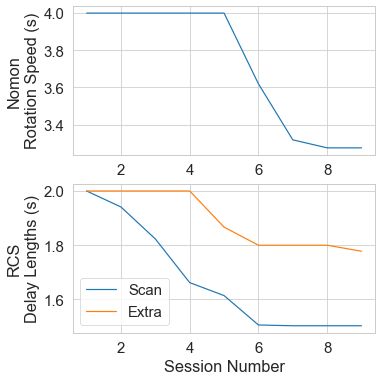

AVG SCAN DELAY:  1.6024722570519316


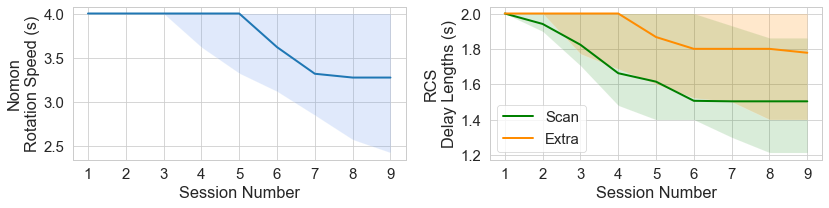

AVG SCAN DELAY:  1.505831359823033


In [165]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2,figsize=(12,3))
plt.tight_layout(w_pad=3)
plt.subplots_adjust(left=0.1)


ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Time Rotate", 
             data=grouped_df[grouped_df["Session Number"] < 10], ax=axes[0], ci=None, estimator=np.median, linewidth=2)
axes[0].set_ylabel("Nomon\nRotation Speed (s)")
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].set_xlabel("")

rotate_quantiles = calculate_quantiles(grouped_df[grouped_df["Session Number"] < 10], "Time Rotate")
axes[0].fill_between(range(1, 10), rotate_quantiles["lower"]["nomon"], rotate_quantiles["upper"]["nomon"],
                where=rotate_quantiles["upper"]["nomon"] >= rotate_quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
                
sns.lineplot(x="Session Number", y="Scan Delay", data=grouped_df[grouped_df["Session Number"] < 10], ax=axes[1], 
             label="Scan", ci=None, estimator=np.median, color="green", linewidth=2)
sns.lineplot(x="Session Number", y="Extra Delay", data=grouped_df[grouped_df["Session Number"] < 10], ax=axes[1],
             label="Extra", ci=None, estimator=np.median, color="darkorange", linewidth=2)
axes[1].set_ylabel("RCS\nDelay Lengths (s)")
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].legend(loc='lower left')

scan_quantiles = calculate_quantiles(grouped_df[grouped_df["Session Number"] < 10], "Scan Delay")
axes[1].fill_between(range(1, 10), scan_quantiles["lower"]["rowcol"], scan_quantiles["upper"]["rowcol"],
                where=scan_quantiles["upper"]["rowcol"] >= scan_quantiles["lower"]["rowcol"], facecolor='green', alpha = 0.15, interpolate=True)
 
extra_quantiles = calculate_quantiles(grouped_df[grouped_df["Session Number"] < 10], "Extra Delay")
axes[1].fill_between(range(1, 10), extra_quantiles["lower"]["rowcol"], extra_quantiles["upper"]["rowcol"],
                where=extra_quantiles["upper"]["rowcol"] >= extra_quantiles["lower"]["rowcol"], facecolor='darkorange', alpha = 0.2, interpolate=True)

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/speed_adjustments.png", dpi=300)
plt.show()

scan_delays = grouped_df[(grouped_df["Session Number"] >= 6) & (grouped_df["Session Number"] < 7)]["Scan Delay"].values
scan_delays = scan_delays[~np.isnan(scan_delays)]
print("AVG SCAN DELAY: ", np.median(scan_delays))

13.0
Entry Rate (wpm) 3.1801521649491757 2.5370223399139373
Running Dependant T test
Entry Rate (wpm) {'t': 3.4632236286071154, 'r': 0.7070171550255748, 'p': 0.004689191460215394} 

Click Load (clicks/char) 1.4223289548961273 1.4570083280308026
Normality Assumption Violated. Running Wilcoxin 0.5716255307197571 3.764517532545142e-05
Click Load (clicks/char) {'Z': 27.0, 'r': 0.2967032967032967, 'p': 0.1960509634811064} 

Correction Rate 0.02358931253854152 0.04271656171348274
Running Dependant T test
Correction Rate {'t': -2.174197305244319, 'r': 0.5316039339527193, 'p': 0.05041482876789149} 

Final Error Rate 0.0050017578863732716 0.005596684017736649
Normality Assumption Violated. Running Wilcoxin 0.7213557958602905 0.000915262964554131
Final Error Rate {'Z': 7.0, 'r': 0.07692307692307693, 'p': 0.892738400944348} 



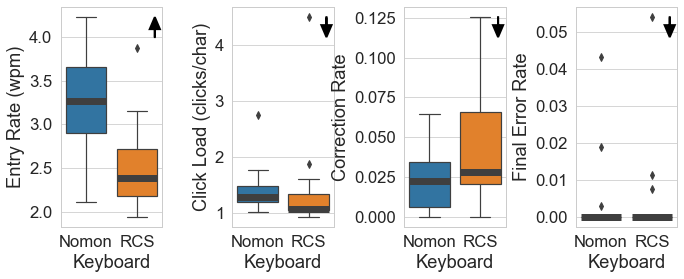

c:\users\nickb\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


{'Final Entry Rate (wpm)': 0.004689191460215394,
 'Final Click Load (clicks/char)': 0.1960509634811064,
 'Final Correction Rate': 0.05041482876789149,
 'Final Final Error Rate': 0.892738400944348}

In [112]:

sns.set_context("paper", font_scale=1.9)
sns.set_style("whitegrid")

final_df = grouped_df[(grouped_df["Session Number"] >= 9) & (grouped_df["Session Number"] < 10)]
final_df = final_df.groupby(['id', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
final_df.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
final_df = final_df.reset_index()

print(len(final_df.id.values)/2)

entry_stats = ["Entry Rate (wpm)", "Click Load (clicks/char)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(1, 4,figsize=(10,4))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(left=0.1)
axes = list(axes)
# fig.suptitle('Entry Statistics for Sessions 7-9')

for entry_stat in entry_stats:
    cur_ax = axes.pop(0)
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=final_df, ax=cur_ax)
    if entry_stat == "Entry Rate (wpm)":
        y_max = np.max(final_df[entry_stat])
        y_min = np.min(final_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max - arrow_h, 0, arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    else:
        y_max = np.max(final_df[entry_stat])
        y_min = np.min(final_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
    plt.plot()

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/final_sessions_metrics.png", dpi=300)
plt.show()

pvalues = {}
for entry_stat in entry_stats:       
    nomon_data = final_df[final_df.Keyboard == "Nomon"][entry_stat].values
    rowcol_data = final_df[final_df.Keyboard == "RCS"][entry_stat].values
    print(entry_stat, np.mean(nomon_data), np.mean(rowcol_data))
    
    cur_pvalue = test_significance(nomon_data, rowcol_data)
    print(entry_stat, cur_pvalue, "\n")
    
    pvalues["Final "+ entry_stat] = cur_pvalue['p']

save_pvalues(pvalues)
pvalues


13.0
Entry Rate (selections/min) 6.642790440708884 4.882735236105187
Running Dependant T test
Entry Rate (selections/min) {'t': 5.238526571445211, 'r': 0.8341205143384879, 'p': 0.00020828150909598007} 

Click Load (clicks/char) 3.503109428926767 2.218440824218183
Running Dependant T test
Click Load (clicks/char) {'t': 7.733285642502349, 'r': 0.9126213392341814, 'p': 5.311084762912319e-06} 

Correction Rate 0.011091780391868847 0.02589190407777797
Running Dependant T test
Correction Rate {'t': -2.4497223388433276, 'r': 0.5773868163991319, 'p': 0.03060874390779564} 

Final Error Rate 0.0025 0.004301137459032196
Normality Assumption Violated. Running Wilcoxin 0.7199859023094177 0.0008858829969540238
Final Error Rate {'Z': 7.0, 'r': 0.07692307692307693, 'p': 0.892738400944348} 



c:\users\nickb\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


{'Emoji Entry Rate (selections/min)': 0.00020828150909598007,
 'Emoji Click Load (clicks/char)': 5.311084762912319e-06,
 'Emoji Correction Rate': 0.03060874390779564,
 'Emoji Final Error Rate': 0.892738400944348}

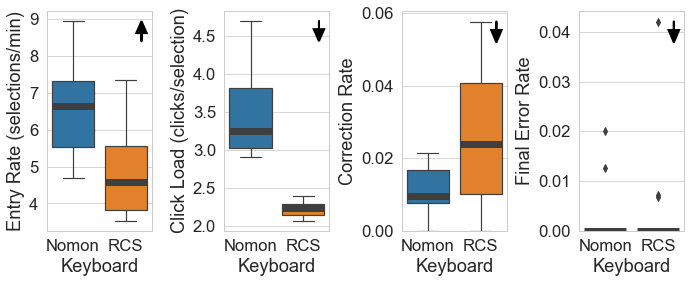

In [18]:
emoji_df = grouped_df[grouped_df["Session Number"] == 10]
print(len(emoji_df.id.values)/2)

entry_stats = ["Entry Rate (selections/min)", "Click Load (clicks/char)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(1, 4,figsize=(10,4))
fig.tight_layout(w_pad=1.6)
axes = list(axes)
# fig.suptitle('Entry Statistics for Emoji Entry')

for entry_stat in entry_stats:
    cur_ax = axes.pop(0)
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=emoji_df, ax=cur_ax)
    
    if entry_stat == "Entry Rate (selections/min)":
        y_max = np.max(emoji_df[entry_stat])
        y_min = np.min(emoji_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.3, y_max - arrow_h, 0, arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    else:
        y_max = np.max(emoji_df[entry_stat])
        y_min = np.min(emoji_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.3, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    
    if entry_stat == "Click Load (clicks/char)":
        cur_ax.set_ylabel("Click Load (clicks/selection)")
    
    if cur_ax.get_ylim()[0] < 0:
        cur_ax.set_ylim(bottom=0.)
    # if entry_stat in ["Correction Rate", "Final Error Rate"]:
    #     if cur_ax.get_ylim()[1] < 1:
    #         cur_ax.set_ylim(top=2)
    
    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
        
    plt.plot()
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/emoji_metrics.png")

pvalues = {}
for entry_stat in entry_stats:       
    nomon_data = emoji_df[emoji_df.Keyboard == "Nomon"][entry_stat].values
    rowcol_data = emoji_df[emoji_df.Keyboard == "RCS"][entry_stat].values
    print(entry_stat, np.mean(nomon_data), np.mean(rowcol_data))
    # plt.hist(nomon_data - np.average(nomon_data))
    # plt.hist(rowcol_data - np.average(rowcol_data))
    # plt.show()
    try:
        cur_pvalue = test_significance(nomon_data, rowcol_data)
        print(entry_stat, cur_pvalue, "\n")
        pvalues["Emoji "+ entry_stat] = cur_pvalue['p']
    except(ValueError):
        pass

save_pvalues(pvalues)
pvalues


<AxesSubplot:xlabel='Session Number', ylabel='Correction Rate (%)'>

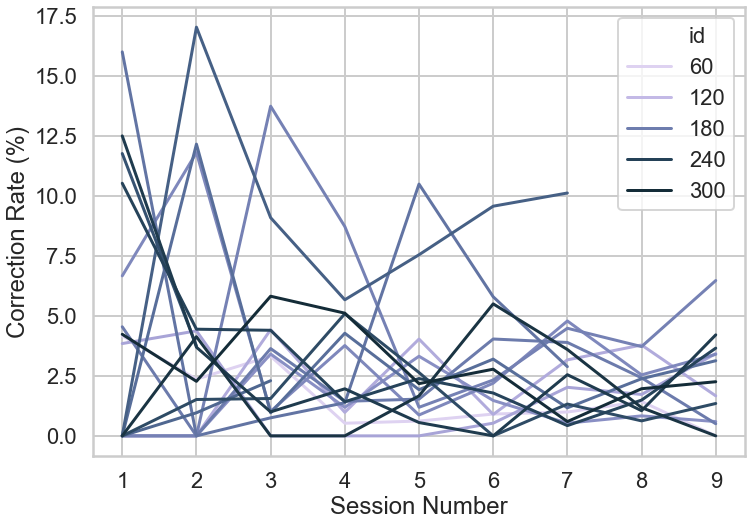

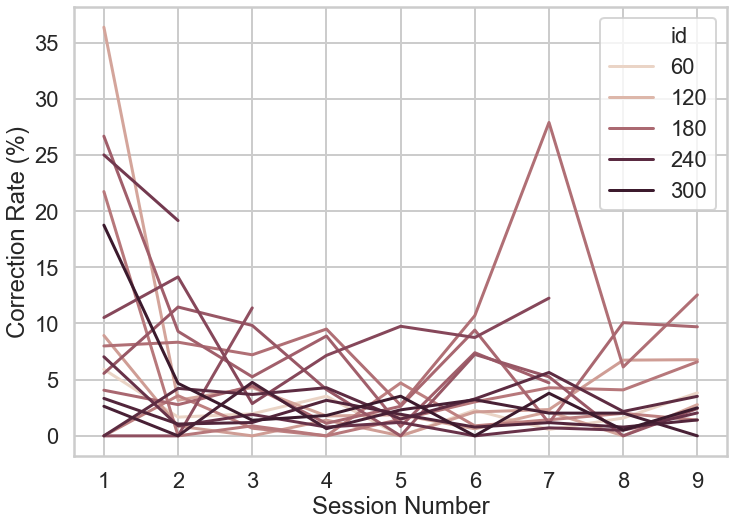

In [24]:
sns.set_context("poster")
sns.set_style("whitegrid")

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Correction Rate", hue="id",
              data=grouped_df[(grouped_df["Session Number"] > 0) & (grouped_df["Session Number"] <= 9) & 
                            (grouped_df["Keyboard"] == "Nomon")], ax=ax, palette="ch:2.5,.25", ci=None)

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(x="Session Number", y="Correction Rate", hue="id",
              data=grouped_df[(grouped_df["Session Number"] > 0) & (grouped_df["Session Number"] <= 9) & 
                            (grouped_df["Keyboard"] == "RCS")], ax=ax, palette="ch:0.5,.25", ci=None)

<AxesSubplot:xlabel='Session Number', ylabel='Correction Rate (%)'>

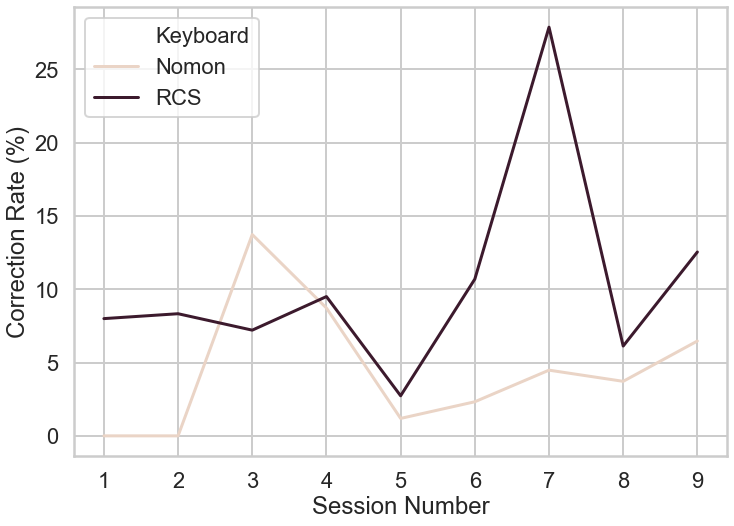

In [23]:
a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x="Session Number", y="Correction Rate", hue="Keyboard",
              data=grouped_df[(grouped_df["Session Number"] > 0) & (grouped_df["Session Number"] <= 9) & 
                            (grouped_df["id"] == 175)], ax=ax, palette="ch:0.5,.25", ci=None)

Entry Rate (wpm) 2.321071906595026 1.9032214208055118
Running Dependant T test
Final Error Rate {'t': 3.949310437468764, 'r': 0.6198320361018398, 'p': 0.0005642675575534525} 

Entry Rate (wpm) 3.482481867504308 3.079839859271604
Running Dependant T test
Final Error Rate {'t': 2.252356283157527, 'r': 0.41072196245863724, 'p': 0.033327558396711685} 

Correction Rate 0.026176485176991247 0.05107811537172223
Running Dependant T test
Final Error Rate {'t': -2.419763412196795, 'r': 0.43562052688202413, 'p': 0.02313312927486177} 

Correction Rate 0.019218815943541852 0.028856418134832636
Normality Assumption Violated. Running Wilcoxin 0.8984050750732422 0.014425765722990036
Final Error Rate {'Z': 112.0, 'r': 0.3190883190883191, 'p': 0.17421027639617592} 



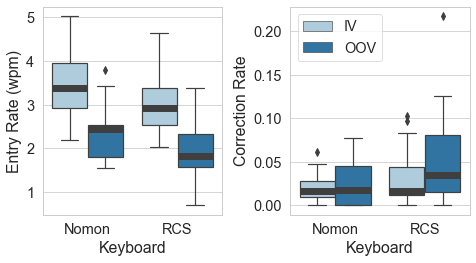

In [88]:
oov_df = entry_df.groupby(['id', 'Session Number', 'Keyboard', 'is_oov']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean']})
oov_df.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Correction Rate',
                    'Final Error Rate']
oov_df = oov_df.reset_index()
oov_df = oov_df[(oov_df["Session Number"] < 10) & (oov_df["Session Number"] >=8)]

fig, axes = plt.subplots(1, 2,figsize=(7,4))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(bottom=0.2)

sns.set_context("paper", font_scale=1.65)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))

for ax_ind, metric in enumerate(['Entry Rate (wpm)', "Correction Rate"]):
    ax = axes[ax_ind]
    sns.boxplot(x="Keyboard", y=metric, hue='is_oov', data=oov_df, ax=ax)
    lines = ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
    
    if ax_ind == 0:
        ax.get_legend().remove()
    else:
        ax.get_legend().set_title('')
        
    nomon_data = oov_df[(oov_df.Keyboard == "Nomon") & (oov_df.is_oov == "OOV")][metric].values
    rowcol_data = oov_df[(oov_df.Keyboard == "RCS") & (oov_df.is_oov == "OOV")][metric].values
    print(metric, np.mean(nomon_data), np.mean(rowcol_data))
    # 
    cur_pvalue = test_significance(nomon_data, rowcol_data)
    print(entry_stat, cur_pvalue, "\n")
    
    nomon_data = oov_df[(oov_df.Keyboard == "Nomon") & (oov_df.is_oov == "IV")][metric].values
    rowcol_data = oov_df[(oov_df.Keyboard == "RCS") & (oov_df.is_oov == "IV")][metric].values
    print(metric, np.mean(nomon_data), np.mean(rowcol_data))
    # 
    cur_pvalue = test_significance(nomon_data, rowcol_data)
    print(entry_stat, cur_pvalue, "\n")
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/oov_metrics.png", dpi=300)
